In [1]:
import pickle
import nltk
from glob import glob
from gensim.models import KeyedVectors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.vocab as vocab
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
gensim_model = KeyedVectors.load_word2vec_format('models/1200_1507.txt')
model_vocab = gensim_model.wv.vocab

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [3]:
class vocabulary():
    
    def __init__(self,model_vocab):
        self.word2idx = {word:model_vocab[word].index+1 for word in list(model_vocab)}
        self.pad_token = 0
        self.word2idx['<padtoken>'] = self.pad_token
        self.idx2word = {value:key for key,value in self.word2idx.items()}
        self.unkid = len(self.word2idx)+1
        
    def __len__(self):
        return len(self.word2idx)

    def __getitem__(self, word):
        return self.word2idx.get(word, self.unkid)

    def __contains__(self, word):
        return word in self.word2idx
    
    def id2word(self, wid):
        return self.idx2word[wid]
    
    def words2indices(self, sents):
        if type(sents[0]) == list:
            return [[self[w] for w in s] for s in sents]
        else:
            return [self[w] for w in sents]

    def indices2words(self, word_ids):
        return [self.idx2word[w_id] for w_id in word_ids]

    def pad_sents(self,sents, pad_token):
        sents_padded = []
        sents_lens = [len(sentence) for sentence in sents]
        max_sent_len = max(sents_lens)
        for sentence in sents:
            sents_padded.append(sentence)
            for _ in range(max_sent_len-len(sentence)):
                sents_padded[-1].append(pad_token)
        return sents_padded
    
    def to_input_tensor(self,sents,device=torch.device('cuda:0')):
#         word_ids = self.words2indices(sents)
        word_ids = sents
        sents_t = self.pad_sents(word_ids, self['<padtoken>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return torch.t(sents_var)

In [4]:
all_comps = pd.read_csv('Reports_2008.csv')

In [5]:
all_comps.head()

,cik,Tables,Images,Text
0,1000180,165.0,1.0,10-K 1 f38194e10vk.htm FORM 10-K e10vk Washin...
1,1000697,128.0,1.0,10-K 1 b68112wce10vk.htm WATERS CORPORATION e...
2,1001250,77.0,0.0,10-K 1 a08-22004_110k.htm 10-K Table of Conten...
3,1001288,184.0,1.0,"10-K 1 l29751ae10vk.htm LEXMARK INTERNATIONAL,..."
4,1002047,142.0,1.0,10-K 1 f38790e10vk.htm FORM 10-K e10vk Washin...


In [6]:
all_comps.loc[0,'Text']

'10-K 1 f38194e10vk.htm FORM 10-K  e10vk Washington, D.C. 20549 Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.  Yes þ     No o Indicate by check mark if the registrant is not required to file reports pursuant to Section 13 or Section 15d of the Exchange Act.  Yes o     No þ Indicate by check mark whether the registrant 1 has filed all reports required to be filed by Section 13 or 15d of the Securities Exchange Act of 1934 during the preceding 12 months or for such shorter period that the registrant was required to file such reports, and 2 has been subject to such filing requirements for the past 90 days.  Yes þ     No o Indicate by check mark if disclosure of delinquent filers pursuant to Item 405 of Regulation S-K is not contained herein, and will not be contained, to the best of registrants knowledge, in definitive proxy or information statements incorporated by reference in Part III of this Form 10-K or any ame

In [466]:
class text_dataset(Dataset):
    
    def __init__(self,text_path,cluster_dict,embedding_dim=300,dataset_type='train'):
        super(text_dataset,self).__init__()
        self.vocabulary = vocabulary(gensim_model.wv.vocab)
        # current implementation requires padtoken to be 0
        self.cluster_dict = cluster_dict
        self.text_path = text_path
        self.dataset_type = dataset_type
        self.prepare_data()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
    
    def prepare_data(self):
        random.seed(20)
        all_sentences = self.get_text()
        random.shuffle(all_sentences)
        train_len = int(0.8*len(all_sentences))
        if [] in all_sentences:
            raise ValueError('found empty list in all_sentences')
        if self.dataset_type == 'train':
            self.X = self.vocabulary.words2indices(all_sentences[:train_len])
            if [] in self.X:
                raise ValueError('found empty list in X')
            self.Y = self.get_clusters(all_sentences[:train_len])
        elif self.dataset_type == 'val':
            self.X = self.vocabulary.words2indices(all_sentences[train_len:])
            self.Y = self.get_clusters(all_sentences[train_len:])
        else :
            self.X = self.vocabulary.words2indices(all_sentences)
            self.Y = self.get_clusters(all_sentences)
            
    def word_count(self):
        count=0
        for x in self.X:
            count+=len(x)
        return count
    
    def get_clusters(self,sentences):
        cluster_ids = []
        for i in range(len(sentences)):
            cluster_ids.append([])
        for i,sentence in enumerate(sentences):
            for word in sentence:
                cluster_ids[i].append(self.get_cluster_idx(word))
        return cluster_ids
        
    def get_cluster_idx(self,key):
        for cluster_idx,cluster in self.cluster_dict.items():
            assert cluster_idx<29,'Cluster idx is problematic'
            if key in cluster:
                return cluster_idx
        return 0
        
    def get_text(self):
        files = glob(f'{self.text_path}/*.txt')
        text = []
        for file in files:
            with open(file) as f:
                raw_text = list(filter(None, f.read().split('\n')))
                f.close()
            int_text = [[x.casefold() for x in line.split(' ') if x.isalpha()] for line in raw_text if len(line.split(' '))>3]
            int_text = list(filter(lambda a: a != [], int_text))
            text.extend(int_text)
        return text    

In [463]:
b = [[1,2,3],[],[],[2,3],[],[0]]
b = list(filter(lambda a: a != [], b))
b

[[1, 2, 3], [2, 3], [0]]

243108

In [229]:
hist = {}
for i in range(29):
    hist[i]=0
for _,y in train_data:
    for idxs in y:
        hist[idxs]+=1

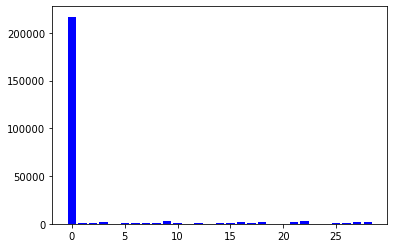

{0: 216870, 1: 439, 2: 614, 3: 1692, 4: 6, 5: 1229, 6: 604, 7: 893, 8: 931, 9: 3181, 10: 371, 11: 112, 12: 1352, 13: 97, 14: 479, 15: 562, 16: 1505, 17: 323, 18: 2105, 19: 254, 20: 156, 21: 1451, 22: 2870, 23: 279, 24: 62, 25: 520, 26: 1004, 27: 1666, 28: 1481}


In [238]:
plt.bar(list(hist.keys()),list(hist.values()),color='b')
plt.show()
print(hist)

In [435]:
clustering_file = open('filtered_dict','rb')
cluster_dict = pickle.load(clustering_file)

In [455]:
class LSTM_model(nn.Module):
    
    def __init__(self,embedding_dim,hidden_dim,gensim_model,vocabulary,num_clusters):
        super(LSTM_model,self).__init__()
        self.gensim_model = gensim_model
        self.embedding_dim = embedding_dim
        self.vocabulary = vocabulary
        self.device = torch.device('cpu')
        self.embedding_layer = nn.Embedding(len(self.vocabulary),embedding_dim,padding_idx=self.vocabulary.pad_token)
        self.reset_vocab_weights()
        self.encoder = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_dim,bias=True,bidirectional=True)
        self.ffn = nn.Sequential(
            nn.Linear(2*hidden_dim,2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim,2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim,num_clusters)
        )
        
    def forward(self,X_padded,sentence_lens):
        # takes tokenised sentences as input, (n,s)
        X = self.embedding_layer(X_padded.t()).permute(1,0,2)
        packed_X = pack_padded_sequence(X,sentence_lens,enforce_sorted=False)
        # encoder takes (s,n,e) inputs
        packed_enc_hiddens, _ = self.encoder(packed_X)
        enc_hiddens = pad_packed_sequence(packed_enc_hiddens)[0].permute(1,0,2)
        out = self.ffn(enc_hiddens).permute(0,2,1)
        # permute to (n,c,d1) since loss is 2d
        return out
        
    def collate_fn(self,batch):
#         print('collate function')
#         print(type(batch))
#         print(batch)
        sentence_lens = [len(sample[0]) for sample in batch]
        sentences_X = [sample[0] for sample in batch]
        sentences_Y = [sample[1] for sample in batch]
#         print(sentences_X)
        X_padded = self.vocabulary.to_input_tensor(sentences_X,device=self.device)
        targets = torch.tensor(self.vocabulary.pad_sents(sents=sentences_Y,pad_token=0),dtype=torch.long)
        return X_padded,targets,sentence_lens
        
    def reset_vocab_weights(self,sanity_check=True):
        # pad token MUST BE 0
        og_state = self.embedding_layer.weight.requires_grad
        self.embedding_layer.weight.requires_grad = False
        self.embedding_layer.weight[0,:] = torch.zeros((self.embedding_dim))
        self.embedding_layer.weight[1:,:] = torch.from_numpy(self.gensim_model.vectors)
        self.embedding_layer.weight.requires_grad = og_state
        if sanity_check:
            embedding_sanity_check = True
            for key,val in final_vocab.idx2word.items():
                if (key>0) and (torch.sum((trial_layer.weight[key,:]-torch.from_numpy(gensim_model[val])).pow(2))>1e-8):
                    embedding_sanity_check = False
            assert embedding_sanity_check, 'Word vectors of embeddings and gensim model do not match!'
        
    def set_embedding_layer_grad(self,state):
        self.embedding_layer.weight.requires_grad = state

In [337]:
input_seq = [[1,3,1,1,1],[2,2,2]]
criterion = nn.CrossEntropyLoss()
pred = dim_model(input_seq)
print(torch.argmax(pred,dim=1))
targets = [[ 1,1,1,1,1],[1,1,1]]
padded_targets = torch.tensor(train_data.vocabulary.pad_sents(sents=targets,pad_token=0),dtype=torch.long)
print(padded_targets)
print(criterion(pred,padded_targets))

tensor([[15, 15, 15, 15, 26],
        [26, 26,  5, 20, 20]])
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0]])
tensor(3.3947, grad_fn=<NllLoss2DBackward>)


In [478]:
def fit(device,dataloaders,model,criterion,optimizer,scheduler=None,tb_logs=None,epochs=1):
        '''
        :param tb_logs: a dictionary containing tensorboard log flag, path and comment
        :param epochs:
        :return:
        '''
        if tb_logs is not None:
            logpath = tb_logs['path']
            logcomment = tb_logs['comment']
            tb = SummaryWriter(log_dir=logpath+f'/{logcomment}', comment=logcomment)
        best_model_wts = copy.deepcopy(model.state_dict())
        best_valid_loss=100.
        for epoch in range(epochs):
            print(f'EPOCH : {epoch + 1}/{epochs}')
            for phase in dataloaders.keys():
                since = time.time()
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                running_loss = 0.
                running_acc = 0.
                running_size = 0
                for inputs,targets,sentence_lens in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
                    with torch.set_grad_enabled(phase=='train'):
                        optimizer.zero_grad()
                        outputs = model(inputs,sentence_lens)
#                         print(outputs)
                        preds = torch.argmax(outputs,dim=1)
                        loss = criterion(outputs, targets)
                        acc = torch.mean((targets==preds).to(float)).item()
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        running_size += outputs.size()[0]*outputs.size()[2]
                        running_loss += loss.item() * inputs.size()[0]*inputs.size()[1]
                        running_acc += acc*inputs.size()[0]*inputs.size()[1]
                #                 if phase == 'train' and not(scheduler is None):
                #                     scheduler.step(epoch_loss)
                epoch_loss = running_loss/running_size
                epoch_acc = running_acc/running_size
                if tb_logs is not None:
                    if phase == 'train':
                        tb.add_scalar('Train Loss', epoch_loss, epoch)
                        tb.add_scalar('Train Acc',epoch_acc,epoch)
                    else:
                        tb.add_scalar('Valid Loss', epoch_loss, epoch)
                        tb.add_scalar('Valid Acc', epoch_acc, epoch)
#                 if phase == 'valid' and not (scheduler is None):  
#                     scheduler.step(epoch_loss)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                # deep copy the model
                if phase == 'valid' and epoch_loss < best_valid_loss:
                    best_valid_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
#             if tb_logs is not None:
#                 current_lr = optimizer.param_groups[0]['lr']
#                 tb.add_scalar('Learning Rate', current_lr, epoch)
            print()
        print('Best valid loss: {:4f}'.format(best_valid_loss))
        # load best model weights
#         model.load_state_dict(best_model_wts)
        if tb_logs is not None:
            tb.close()
        return model

In [512]:
train_data = text_dataset(text_path='text_data',cluster_dict=cluster_dict)
val_data = text_dataset(text_path='text_data',cluster_dict=cluster_dict,dataset_type='val')
device = torch.device('cuda:0')
model = LSTM_model(300,100,gensim_model,train_data.vocabulary,num_clusters=29).to(device)
dataloaders={
    'train':DataLoader(train_data,batch_size=100,shuffle=False,collate_fn=model.collate_fn),
    'val':DataLoader(val_data,batch_size=150,shuffle=False,collate_fn=model.collate_fn)
}
loss_weights = [1000]*29
loss_weights[0] = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.tensor(loss_weights,dtype=torch.float32,device=device))
optimizer = torch.optim.SGD(model.parameters(),lr=3e-3,momentum=0.9)

model = fit(device,dataloaders,model,criterion,optimizer,epochs=50)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
  1%|█▏                                                                                | 4/267 [00:00<00:07, 37.15it/s]

EPOCH : 1/50


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 112.42it/s]

train Loss: 3.1953 Acc: 0.0045
Training complete in 0m 8s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 57.28it/s]

val Loss: 2.9829 Acc: 0.0043
Training complete in 0m 0s

EPOCH : 2/50


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 160.81it/s]

train Loss: 2.8539 Acc: 0.0056
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 57.28it/s]

val Loss: 2.7083 Acc: 0.0045
Training complete in 0m 0s

EPOCH : 3/50


 64%|████████████████████████████████████████████████████▏                            | 29/45 [00:00<00:00, 138.67it/s]

train Loss: 2.4160 Acc: 0.0135
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.18it/s]

val Loss: 2.0987 Acc: 0.0173
Training complete in 0m 0s

EPOCH : 4/50


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 160.86it/s]

train Loss: 1.7850 Acc: 0.0216
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 56.21it/s]

val Loss: 1.4794 Acc: 0.0225
Training complete in 0m 0s

EPOCH : 5/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 157.28it/s]

train Loss: 1.1888 Acc: 0.0272
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.69it/s]

val Loss: 0.9570 Acc: 0.0273
Training complete in 0m 0s

EPOCH : 6/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 157.28it/s]

train Loss: 0.7586 Acc: 0.0314
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 57.83it/s]

val Loss: 0.6299 Acc: 0.0305
Training complete in 0m 0s

EPOCH : 7/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 152.80it/s]

train Loss: 0.5043 Acc: 0.0339
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.86it/s]

val Loss: 0.4427 Acc: 0.0324
Training complete in 0m 0s

EPOCH : 8/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 155.75it/s]

train Loss: 0.3612 Acc: 0.0355
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.71it/s]

val Loss: 0.3340 Acc: 0.0334
Training complete in 0m 0s

EPOCH : 9/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 152.85it/s]

train Loss: 0.2742 Acc: 0.0366
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.69it/s]

val Loss: 0.2641 Acc: 0.0341
Training complete in 0m 0s

EPOCH : 10/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 146.02it/s]

train Loss: 0.2165 Acc: 0.0372
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 48.21it/s]

val Loss: 0.2158 Acc: 0.0345
Training complete in 0m 0s

EPOCH : 11/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 140.56it/s]

train Loss: 0.1757 Acc: 0.0376
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 46.42it/s]

val Loss: 0.1803 Acc: 0.0348
Training complete in 0m 0s

EPOCH : 12/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 126.55it/s]

train Loss: 0.1452 Acc: 0.0379
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 50.98it/s]

val Loss: 0.1534 Acc: 0.0351
Training complete in 0m 0s

EPOCH : 13/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.29it/s]

train Loss: 0.1218 Acc: 0.0381
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 50.47it/s]

val Loss: 0.1326 Acc: 0.0353
Training complete in 0m 0s

EPOCH : 14/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 133.69it/s]

train Loss: 0.1035 Acc: 0.0383
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.58it/s]

val Loss: 0.1162 Acc: 0.0355
Training complete in 0m 0s

EPOCH : 15/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.62it/s]

train Loss: 0.0890 Acc: 0.0385
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.58it/s]

val Loss: 0.1031 Acc: 0.0357
Training complete in 0m 0s

EPOCH : 16/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 127.79it/s]

train Loss: 0.0774 Acc: 0.0386
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 47.30it/s]

val Loss: 0.0922 Acc: 0.0358
Training complete in 0m 0s

EPOCH : 17/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 129.98it/s]

train Loss: 0.0679 Acc: 0.0387
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 48.66it/s]

val Loss: 0.0833 Acc: 0.0359
Training complete in 0m 0s

EPOCH : 18/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 148.91it/s]

train Loss: 0.0600 Acc: 0.0388
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.67it/s]

val Loss: 0.0757 Acc: 0.0359
Training complete in 0m 0s

EPOCH : 19/50


 67%|██████████████████████████████████████████████████████                           | 30/45 [00:00<00:00, 147.44it/s]

train Loss: 0.0534 Acc: 0.0388
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.86it/s]

val Loss: 0.0694 Acc: 0.0360
Training complete in 0m 0s

EPOCH : 20/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 147.40it/s]

train Loss: 0.0478 Acc: 0.0389
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.23it/s]

val Loss: 0.0639 Acc: 0.0360
Training complete in 0m 0s

EPOCH : 21/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.57it/s]

train Loss: 0.0429 Acc: 0.0389
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.71it/s]

val Loss: 0.0592 Acc: 0.0361
Training complete in 0m 0s

EPOCH : 22/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 146.02it/s]

train Loss: 0.0387 Acc: 0.0389
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.85it/s]

val Loss: 0.0552 Acc: 0.0361
Training complete in 0m 0s

EPOCH : 23/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 154.25it/s]

train Loss: 0.0350 Acc: 0.0390
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.17it/s]

val Loss: 0.0517 Acc: 0.0361
Training complete in 0m 0s

EPOCH : 24/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 151.35it/s]

train Loss: 0.0317 Acc: 0.0390
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.18it/s]

val Loss: 0.0486 Acc: 0.0362
Training complete in 0m 0s

EPOCH : 25/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 125.30it/s]

train Loss: 0.0288 Acc: 0.0390
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.71it/s]

val Loss: 0.0460 Acc: 0.0362
Training complete in 0m 0s

EPOCH : 26/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 148.91it/s]

train Loss: 0.0262 Acc: 0.0391
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.30it/s]

val Loss: 0.0437 Acc: 0.0362
Training complete in 0m 0s

EPOCH : 27/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 151.35it/s]

train Loss: 0.0240 Acc: 0.0391
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.69it/s]

val Loss: 0.0417 Acc: 0.0363
Training complete in 0m 0s

EPOCH : 28/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 149.93it/s]

train Loss: 0.0220 Acc: 0.0391
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.23it/s]

val Loss: 0.0400 Acc: 0.0363
Training complete in 0m 0s

EPOCH : 29/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.61it/s]

train Loss: 0.0203 Acc: 0.0391
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.31it/s]

val Loss: 0.0386 Acc: 0.0363
Training complete in 0m 0s

EPOCH : 30/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 124.14it/s]

train Loss: 0.0188 Acc: 0.0392
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 46.42it/s]

val Loss: 0.0372 Acc: 0.0363
Training complete in 0m 0s

EPOCH : 31/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 122.97it/s]

train Loss: 0.0174 Acc: 0.0392
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 46.85it/s]

val Loss: 0.0361 Acc: 0.0363
Training complete in 0m 0s

EPOCH : 32/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 141.89it/s]

train Loss: 0.0162 Acc: 0.0392
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 42.49it/s]

val Loss: 0.0350 Acc: 0.0364
Training complete in 0m 0s

EPOCH : 33/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.28it/s]

train Loss: 0.0151 Acc: 0.0394
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 46.85it/s]

val Loss: 0.0341 Acc: 0.0365
Training complete in 0m 0s

EPOCH : 34/50


 62%|██████████████████████████████████████████████████▍                              | 28/45 [00:00<00:00, 138.16it/s]

train Loss: 0.0141 Acc: 0.0405
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 46.85it/s]

val Loss: 0.0333 Acc: 0.0375
Training complete in 0m 0s

EPOCH : 35/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 120.69it/s]

train Loss: 0.0132 Acc: 0.0431
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.56it/s]

val Loss: 0.0325 Acc: 0.0403
Training complete in 0m 0s

EPOCH : 36/50


 58%|██████████████████████████████████████████████▊                                  | 26/45 [00:00<00:00, 128.68it/s]

train Loss: 0.0124 Acc: 0.0486
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.16it/s]

val Loss: 0.0319 Acc: 0.0461
Training complete in 0m 0s

EPOCH : 37/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 127.79it/s]

train Loss: 0.0116 Acc: 0.0649
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 47.30it/s]

val Loss: 0.0313 Acc: 0.0831
Training complete in 0m 0s

EPOCH : 38/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 129.06it/s]

train Loss: 0.0109 Acc: 0.1254
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.99it/s]

val Loss: 0.0307 Acc: 0.4358
Training complete in 0m 0s

EPOCH : 39/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 131.19it/s]

train Loss: 0.0103 Acc: 0.2279
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 44.75it/s]

val Loss: 0.0303 Acc: 0.5147
Training complete in 0m 0s

EPOCH : 40/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 146.02it/s]

train Loss: 0.0097 Acc: 0.3316
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.69it/s]

val Loss: 0.0298 Acc: 0.5701
Training complete in 0m 0s

EPOCH : 41/50


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 127.79it/s]

train Loss: 0.0092 Acc: 0.4141
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 41.78it/s]

val Loss: 0.0294 Acc: 0.5951
Training complete in 0m 0s

EPOCH : 42/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 147.45it/s]

train Loss: 0.0087 Acc: 0.4816
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.42it/s]

val Loss: 0.0291 Acc: 0.6319
Training complete in 0m 0s

EPOCH : 43/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.22it/s]

train Loss: 0.0083 Acc: 0.5519
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.86it/s]

val Loss: 0.0287 Acc: 0.6392
Training complete in 0m 0s

EPOCH : 44/50


 64%|████████████████████████████████████████████████████▏                            | 29/45 [00:00<00:00, 140.63it/s]

train Loss: 0.0079 Acc: 0.5916
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.42it/s]

val Loss: 0.0285 Acc: 0.6442
Training complete in 0m 0s

EPOCH : 45/50


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 149.93it/s]

train Loss: 0.0075 Acc: 0.6128
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.69it/s]

val Loss: 0.0282 Acc: 0.6484
Training complete in 0m 0s

EPOCH : 46/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.29it/s]

train Loss: 0.0071 Acc: 0.6272
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.31it/s]

val Loss: 0.0279 Acc: 0.6524
Training complete in 0m 0s

EPOCH : 47/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 148.91it/s]

train Loss: 0.0068 Acc: 0.6364
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.31it/s]

val Loss: 0.0277 Acc: 0.6559
Training complete in 0m 0s

EPOCH : 48/50


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.62it/s]

train Loss: 0.0065 Acc: 0.6454
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.93it/s]

val Loss: 0.0275 Acc: 0.6592
Training complete in 0m 0s

EPOCH : 49/50


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 145.97it/s]

train Loss: 0.0062 Acc: 0.6526
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.30it/s]

val Loss: 0.0273 Acc: 0.6625
Training complete in 0m 0s

EPOCH : 50/50


 67%|██████████████████████████████████████████████████████                           | 30/45 [00:00<00:00, 145.46it/s]

train Loss: 0.0059 Acc: 0.6593
Training complete in 0m 5s


100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 147.45it/s]

val Loss: 0.0271 Acc: 0.6661
Training complete in 0m 0s

Best valid loss: 100.000000


In [513]:
val_outs = []
val_targets = []
for inputs,targets,sentence_lens in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 178.33it/s]


In [514]:
consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)

([3248, 575, 152, 316, 745, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
([3531, 124, 7, 1605, 19, 185, 610, 109, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [530]:
fval_words = []
fval_preds = []
for inputs,targets,sentence_lens in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).permute(1,0)
        words = inputs.flatten()
        word_preds = preds.flatten()
        for i in range(words.size()[0]):
            if words[i].item() != 0:
                fval_words.append(train_data.vocabulary.idx2word[words[i].item()])
                fval_preds.append(word_preds[i].item())

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.68it/s]


In [533]:
cluster_preds = {}
for i in range(29):
    cluster_preds[i]=[]
for word,pred in zip(fval_words,fval_preds):
    cluster_preds[pred].append(word)
for i in range(29):
    cluster_preds[i]=list(set(cluster_preds[i]))

In [541]:
file1 = open('first_run_preds.pkl','wb')
pickle.dump(cluster_preds,file1)
file1.close()
file2 = open('first_run_og.pkl','wb')
pickle.dump(cluster_dict,file2)
file2.close()

In [559]:
x = 16
print(cluster_preds[x])
print(cluster_dict[x])

['wgi', 'biotic', 'hypoxemia', 'stee', 'whe', 'lampitt', 'calcify', 'lakebeds', 'milly', 'illustrative', 'arr', 'rng', 'chroniclers', 'seasonality', 'situ', 'plagues', 'multiscale', 'ellie', 'ottmar', 'cloudier', 'pauline', 'wm', 'avoidable', 'sérgio', 'homeostatic', 'dx', 'stimulatory', 'inversely', 'cdr', 'bathypelagic', 'cece', 'troposphere', 'berkes', 'chem', 'exacerbation', 'breakpoints', 'modulations', 'poleward', 'ei', 'continuations', 'attributional', 'neutralization', 'localized', 'hsd', 'priori', 'scaler', 'eal', 'concessional', 'gnv', 'disrupts', 'timescale', 'huxleyi', 'insolation', 'raper', 'photosystem', 'borehole', 'susanne', 'regulary', 'nuttall', 'typologies', 'constrains', 'overestimation', 'limacina', 'skiba', 'hore', 'gf', 'nonlinear', 'baselines', 'phenology', 'upwelling', 'tor', 'sio', 'thickening', 'hwp', 'urbanization', 'vv', 'reto', 'renner', 'wanninkhof', 'lemelin', 'modifies', 'gridded', 'biophysical', 'timescales', 'arbuscula', 'porites', 'depletions', 'thre

In [515]:
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')

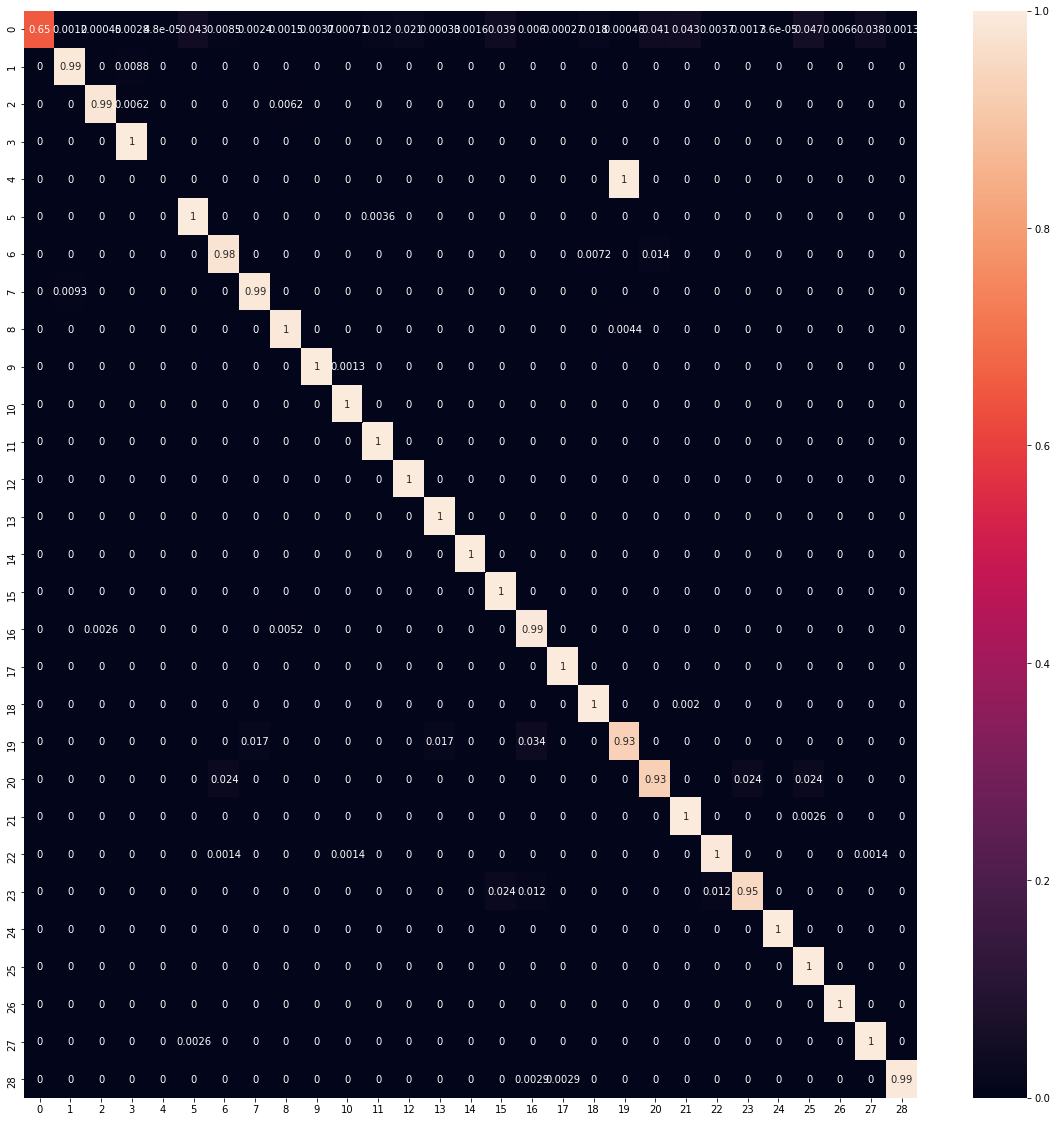

In [516]:
df_cm = pd.DataFrame(cm, index = [i for i in range(29)],
                  columns = [i for i in range(29)])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)